**Install required library**

In [ ]:
!pip install datasets
!pip install transformers[torch] # Install transformers with torch support
!pip install torch
!pip install torchvision --no-cache-dir --force-reinstall --index-url https://download.pytorch.org/whl/cu118
!pip install googletrans==3.1.0a0


**Loading and downloading required dataset**

In [ ]:
import json
from datasets import load_dataset
import random

def load_squad_and_save_json(filename="squad_50.json", num_samples=50):
    # Load the SQuAD dataset.  We use the 'plain_text' version, which is easiest
    # to work with for many applications.
    squad_dataset = load_dataset("squad", split="train")

    # Check if the dataset was loaded correctly
    if not squad_dataset:
        print("Error: Failed to load the SQuAD dataset.")
        return

    # Get the total number of examples in the dataset
    total_samples = len(squad_dataset)

    # Check if the requested number of samples is valid
    if num_samples > total_samples:
        print(f"Warning: Requested {num_samples} samples, but the dataset only contains {total_samples} samples.  Using the entire dataset.")
        num_samples = total_samples

    # Create a list of indices, shuffle it, and take the first num_samples
    indices = list(range(total_samples))
    random.shuffle(indices)
    selected_indices = indices[:num_samples]

    # Create a new dataset with the selected samples
    selected_dataset = squad_dataset.select(selected_indices)

    # Convert the selected dataset to a list of dictionaries, which is easier to
    # handle and convert to JSON.  We only need a few key fields.
    data_list = []
    for item in selected_dataset:
        #  Handle potential errors or missing fields.  The SQuAD dataset
        #  should be well-formed, but it's good practice to be robust.
        if 'question' not in item or 'context' not in item or 'answers' not in item or 'id' not in item:
            print(f"Warning: Skipping item with missing fields: {item}")
            continue

        question = item['question']
        context = item['context']
        answers = item['answers']
        item_id = item['id']

        # Further check the structure of the 'answers'
        if not isinstance(answers, dict) or 'text' not in answers or 'answer_start' not in answers:
             print(f"Warning: Skipping item with invalid 'answers' format: {item['answers']}")
             continue
        if not isinstance(answers['text'], list) or not isinstance(answers['answer_start'], list):
             print(f"Warning: Skipping item with invalid 'answers' sub-format: {item['answers']}")
             continue

        # Ensure that the 'text' and 'answer_start' lists have the same length.
        if len(answers['text']) != len(answers['answer_start']):
            print(f"Warning: Skipping item where 'answers' text and start lists have different lengths: {item['answers']}")
            continue

        # Take only the first answer.  Some SQuAD examples have multiple
        # possible answers, but for fine-tuning, we often simplify to a single answer.
        if answers['text']:
            first_answer_text = answers['text'][0]
            first_answer_start = answers['answer_start'][0]
        else:
            print(f"Warning: Skipping item with empty answer text list: {item['answers']}")
            continue

        data_list.append({
            'id': item_id,
            'question': question,
            'context': context,
            'answer_text': first_answer_text,
            'answer_start': first_answer_start,
        })

    # Convert the list of dictionaries to a JSON string
    json_data = json.dumps(data_list, indent=4)

    # Write the JSON string to a file
    try:
        with open(filename, 'w') as f:
            f.write(json_data)
        print(f"Successfully saved {len(data_list)} samples to {filename}")
    except Exception as e:
        print(f"Error writing to file {filename}: {e}")
        return

if __name__ == "__main__":
    load_squad_and_save_json(num_samples=50)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Successfully saved 50 samples to squad_50.json


**# Fine Tuning and Evaluating Multilingual bert (English)**

In [ ]:
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForQuestionAnswering, BertTokenizer
from torch.optim import AdamW # Import AdamW from torch.optim
from transformers import BertForQuestionAnswering, BertTokenizerFast, get_linear_schedule_with_warmup # Import BertTokenizerFast and get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import f1_score
import re
import string # Import the string module


def compute_f1(predictions, references):

    def normalize_string(s):
        """Lower text and remove punctuation, articles and extra whitespace."""
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)

        def white_space_fix(text):
            return ' '.join(text.strip().split())

        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)

        def lower(text):
            return text.lower()

        return white_space_fix(remove_articles(remove_punc(lower(s))))

    f1_scores = []
    for prediction, reference in zip(predictions, references):
        # Handle empty predictions or references
        if not prediction or not reference:
            if not prediction and not reference:
                f1_scores.append(1.0)  # Both empty, perfect match
            else:
                f1_scores.append(0.0)  # One empty, no match
            continue

        prediction_tokens = normalize_string(prediction).split()
        reference_tokens = normalize_string(reference).split()

        common = [w for w in prediction_tokens if w in reference_tokens]
        num_same = len(common)

        if num_same == 0:
            f1_scores.append(0.0)
            continue

        precision = num_same / len(prediction_tokens)
        recall = num_same / len(reference_tokens)
        f1 = (2 * precision * recall) / (precision + recall)
        f1_scores.append(f1)
    return sum(f1_scores) / len(f1_scores) if f1_scores else 0.0 # handle the case where the list is empty.


def read_squad_json(file_path):

    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


def preprocess_data(data, tokenizer, max_length=384, doc_stride=128):

    input_ids = []
    attention_masks = []
    start_positions = []
    end_positions = []
    example_ids = []

    for example in data:
        question_text = example['question']
        context_text = example['context']
        answer_text = example['answer_text']
        example_id = example['id']

        # Tokenize the question and context, handling long contexts with stride
        tokenized_context = tokenizer.encode_plus(
            context_text,
            truncation=True,  # Don't truncate here, handle with sliding window
            add_special_tokens=False,  # We'll add them later
            return_offsets_mapping=True,  # Get character-to-token mappings
            return_overflowing_tokens=True,  # Return long contexts as multiple features
            max_length=max_length - len(tokenizer.encode(question_text, add_special_tokens=False)) - 3, # adjust max_length for context to account for question and special tokens
            stride=doc_stride
        )

        # Tokenize the question
        tokenized_question = tokenizer.encode_plus(
            question_text,
            add_special_tokens=False,
            return_attention_mask=False,  # We'll create a combined mask later
        )

        # The 'overflowing_tokens' and 'offset_mapping' are the key to handling long contexts
        for i in range(len(tokenized_context['input_ids'])):  # Loop through the features created from long context
            # Get the input_ids, token_type_ids and attention mask for each context
            context_input_ids = tokenized_context['input_ids'][i]
            context_attention_mask = tokenized_context['attention_mask'][i] if 'attention_mask' in tokenized_context else [
                                                                                                                      1] * len(
                context_input_ids)
            context_offsets = tokenized_context['offset_mapping'][i]

            # Combine question and context, [CLS] question [SEP] context [SEP]
            combined_input_ids = [tokenizer.cls_token_id] + tokenized_question['input_ids'] + [
                tokenizer.sep_token_id] + context_input_ids + [tokenizer.sep_token_id]
            combined_attention_mask = [1] + [1] * len(tokenized_question['input_ids']) + [1] + context_attention_mask + [
                1]
            # Pad to max_length
            padding_length = max_length - len(combined_input_ids)
            if padding_length > 0:
                combined_input_ids = combined_input_ids + [tokenizer.pad_token_id] * padding_length
                combined_attention_mask = combined_attention_mask + [0] * padding_length

            # This is necessary if the question + context is still longer than max_length after doc_stride
            # This truncation will cut off part of the context
            if len(combined_input_ids) > max_length:
                combined_input_ids = combined_input_ids[:max_length]
                combined_attention_mask = combined_attention_mask[:max_length]
            # Find the start and end positions of the answer in the context *within this span*
            start_char = example['answer_start']
            end_char = start_char + len(answer_text)

            # Initialize to 0, in case we don't find a valid start/end
            start_position = 0
            end_position = 0

            # Loop through the context offsets to find the *token* position of the answer
            for idx, (start_offset, end_offset) in enumerate(context_offsets):
                if start_offset <= start_char and end_offset >= start_char:
                    start_position = len(tokenized_question['input_ids']) + 2 + idx  # +2 for [CLS], [SEP]
                if start_offset <= end_char and end_offset >= end_char:
                    end_position = len(tokenized_question['input_ids']) + 2 + idx

            # Handle the case where the answer is out of the current context window
            if start_position == 0 and end_position == 0:
                start_position = 0
                end_position = 0

            input_ids.append(combined_input_ids)
            attention_masks.append(combined_attention_mask)
            start_positions.append(start_position)
            end_positions.append(end_position)
            example_ids.append(example_id)

    return input_ids, attention_masks, start_positions, end_positions, example_ids


def create_dataloader(input_ids, attention_masks, start_positions, end_positions, batch_size):

    all_input_ids = torch.tensor(input_ids, dtype=torch.long)
    all_attention_masks = torch.tensor(attention_masks, dtype=torch.long)
    all_start_positions = torch.tensor(start_positions, dtype=torch.long)
    all_end_positions = torch.tensor(end_positions, dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_masks, all_start_positions, all_end_positions)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def fine_tune_and_evaluate(train_data, val_data, model_name="bert-base-multilingual-cased",
                            batch_size=10, epochs=3, learning_rate=3e-5,
                            max_length=384, doc_stride=128):

    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    model = BertForQuestionAnswering.from_pretrained(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Preprocess the training and validation data
    train_input_ids, train_attention_masks, train_start_positions, train_end_positions, train_example_ids = preprocess_data(
        train_data, tokenizer, max_length, doc_stride)
    val_input_ids, val_attention_masks, val_start_positions, val_end_positions, val_example_ids = preprocess_data(
        val_data, tokenizer, max_length, doc_stride)

    # Create DataLoaders
    train_dataloader = create_dataloader(train_input_ids, train_attention_masks, train_start_positions,
                                         train_end_positions, batch_size)
    val_dataloader = create_dataloader(val_input_ids, val_attention_masks, val_start_positions,
                                       val_end_positions, batch_size)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                num_training_steps=total_steps)  # Changed variable name

    # Fine-tuning loop
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for batch in tqdm(train_dataloader, desc="Training"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "start_positions": batch[2],
                "end_positions": batch[3],
            }
            model.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Evaluation on the validation set
    model.eval()
    print("Evaluating on the validation set...")
    all_predicted_answers = []
    all_reference_answers = []
    all_val_ids = []  # Collect IDs for matching

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
            }
            outputs = model(**inputs)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            # Get the predicted start and end positions
            start_positions = torch.argmax(start_logits, dim=-1).cpu().tolist()
            end_positions = torch.argmax(end_logits, dim=-1).cpu().tolist()

            # Get the input IDs and convert them to text
            input_ids_batch = batch[0].cpu().tolist()

            # Decode the predicted answer
            for i in range(len(input_ids_batch)):
                input_ids = input_ids_batch[i]
                start_pos = start_positions[i]
                end_pos = end_positions[i]

                # Ensure start_pos <= end_pos
                if start_pos > end_pos:
                    predicted_answer_text = ""  # Or some other default value
                else:
                    tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)
                    predicted_answer_text = tokenizer.convert_tokens_to_string(
                        tokens[start_pos:end_pos + 1])
                all_predicted_answers.append(predicted_answer_text)

        # Get the *reference* answers from the original validation data, matching by ID
        for val_example in val_data:
            all_val_ids.append(val_example['id'])

        for val_id in val_example_ids:
            index = all_val_ids.index(val_id)  # find the index
            all_reference_answers.append(val_data[index]['answer_text'])

    # Calculate F1 score
    f1 = compute_f1(all_predicted_answers, all_reference_answers)
    print(f"F1 Score on the validation set: {f1:.4f}")

    # Save the fine-tuned model
    model.save_pretrained("fine_tuned_mbert_model")
    tokenizer.save_pretrained("fine_tuned_mbert_model")


if __name__ == "__main__":
    # Load your SQuAD-formatted JSON data
    train_data = read_squad_json("squad_40.json")
    val_data = read_squad_json("squad_40.json")  # using the same data for simplicity

    # Fine-tune and evaluate the model
    fine_tune_and_evaluate(train_data, val_data, model_name="bert-base-multilingual-cased")


**Store the model_type, Dataset type and f1 score in dataframe**

In [ ]:
import pandas as pd

# Initial DataFrame
df = pd.DataFrame({
    'Model': ["Multilingual bert"],
    'Dataset': ["English"],
    "F1_Score":[f1]
})

**# Fine Tuning and Evaluating Monolingual bert (English)**

In [ ]:
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForQuestionAnswering, BertTokenizer
from torch.optim import AdamW # Import AdamW from torch.optim
from transformers import BertForQuestionAnswering, BertTokenizerFast, get_linear_schedule_with_warmup # Import BertTokenizerFast and get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import f1_score
import re
import string # Import the string module

def compute_f1(predictions, references):

    def normalize_string(s):
        """Lower text and remove punctuation, articles and extra whitespace."""
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)

        def white_space_fix(text):
            return ' '.join(text.strip().split())

        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)

        def lower(text):
            return text.lower()

        return white_space_fix(remove_articles(remove_punc(lower(s))))

    f1_scores = []
    for prediction, reference in zip(predictions, references):
        # Handle empty predictions or references
        if not prediction or not reference:
            if not prediction and not reference:
                f1_scores.append(1.0)  # Both empty, perfect match
            else:
                f1_scores.append(0.0)  # One empty, no match
            continue

        prediction_tokens = normalize_string(prediction).split()
        reference_tokens = normalize_string(reference).split()

        common = [w for w in prediction_tokens if w in reference_tokens]
        num_same = len(common)

        if num_same == 0:
            f1_scores.append(0.0)
            continue

        precision = num_same / len(prediction_tokens)
        recall = num_same / len(reference_tokens)
        f1 = (2 * precision * recall) / (precision + recall)
        f1_scores.append(f1)
    return sum(f1_scores) / len(f1_scores) if f1_scores else 0.0 # handle the case where the list is empty.


def read_squad_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


def preprocess_data(data, tokenizer, max_length=384, doc_stride=128):
    input_ids = []
    attention_masks = []
    start_positions = []
    end_positions = []
    example_ids = []

    for example in data:
        question_text = example['question']
        context_text = example['context']
        answer_text = example['answer_text']
        example_id = example['id']

        # Tokenize the question and context, handling long contexts with stride
        tokenized_context = tokenizer.encode_plus(
            context_text,
            truncation=True,  # Don't truncate here, handle with sliding window
            add_special_tokens=False,  # We'll add them later
            return_offsets_mapping=True,  # Get character-to-token mappings
            return_overflowing_tokens=True,  # Return long contexts as multiple features
            max_length=max_length - len(tokenizer.encode(question_text, add_special_tokens=False)) - 3,  # adjust max_length for context to account for question and special tokens
            stride=doc_stride
        )

        # Tokenize the question
        tokenized_question = tokenizer.encode_plus(
            question_text,
            add_special_tokens=False,
            return_attention_mask=False,  # We'll create a combined mask later
        )

        # The 'overflowing_tokens' and 'offset_mapping' are the key to handling long contexts
        for i in range(len(tokenized_context['input_ids'])):  # Loop through the features created from long context
            # Get the input_ids, token_type_ids and attention mask for each context
            context_input_ids = tokenized_context['input_ids'][i]
            context_attention_mask = tokenized_context['attention_mask'][i] if 'attention_mask' in tokenized_context else [
                1] * len(
                context_input_ids)
            context_offsets = tokenized_context['offset_mapping'][i]

            # Combine question and context, [CLS] question [SEP] context [SEP]
            combined_input_ids = [tokenizer.cls_token_id] + tokenized_question['input_ids'] + [
                tokenizer.sep_token_id] + context_input_ids + [tokenizer.sep_token_id]
            combined_attention_mask = [1] + [1] * len(tokenized_question['input_ids']) + [1] + context_attention_mask + [
                1]
            # Pad to max_length
            padding_length = max_length - len(combined_input_ids)
            if padding_length > 0:
                combined_input_ids = combined_input_ids + [tokenizer.pad_token_id] * padding_length
                combined_attention_mask = combined_attention_mask + [0] * padding_length

            # This is necessary if the question + context is still longer than max_length after doc_stride
            # This truncation will cut off part of the context
            if len(combined_input_ids) > max_length:
                combined_input_ids = combined_input_ids[:max_length]
                combined_attention_mask = combined_attention_mask[:max_length]
            # Find the start and end positions of the answer in the context *within this span*
            start_char = example['answer_start']
            end_char = start_char + len(answer_text)

            # Initialize to 0, in case we don't find a valid start/end
            start_position = 0
            end_position = 0

            # Loop through the context offsets to find the *token* position of the answer
            for idx, (start_offset, end_offset) in enumerate(context_offsets):
                if start_offset <= start_char and end_offset >= start_char:
                    start_position = len(tokenized_question['input_ids']) + 2 + idx  # +2 for [CLS], [SEP]
                if start_offset <= end_char and end_offset >= end_char:
                    end_position = len(tokenized_question['input_ids']) + 2 + idx

            # Handle the case where the answer is out of the current context window
            if start_position == 0 and end_position == 0:
                start_position = 0
                end_position = 0

            input_ids.append(combined_input_ids)
            attention_masks.append(combined_attention_mask)
            start_positions.append(start_position)
            end_positions.append(end_position)
            example_ids.append(example_id)

    return input_ids, attention_masks, start_positions, end_positions, example_ids


def create_dataloader(input_ids, attention_masks, start_positions, end_positions, batch_size):

    all_input_ids = torch.tensor(input_ids, dtype=torch.long)
    all_attention_masks = torch.tensor(attention_masks, dtype=torch.long)
    all_start_positions = torch.tensor(start_positions, dtype=torch.long)
    all_end_positions = torch.tensor(end_positions, dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_masks, all_start_positions, all_end_positions)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def fine_tune_and_evaluate(train_data, val_data, model_name="bert-base-uncased",
                        batch_size=10, epochs=3, learning_rate=3e-5,
                        max_length=384, doc_stride=128):

    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    model = BertForQuestionAnswering.from_pretrained(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Preprocess the training and validation data
    train_input_ids, train_attention_masks, train_start_positions, train_end_positions, train_example_ids = preprocess_data(
        train_data, tokenizer, max_length, doc_stride)
    val_input_ids, val_attention_masks, val_start_positions, val_end_positions, val_example_ids = preprocess_data(
        val_data, tokenizer, max_length, doc_stride)

    # Create DataLoaders
    train_dataloader = create_dataloader(train_input_ids, train_attention_masks, train_start_positions,
                                        train_end_positions, batch_size)
    val_dataloader = create_dataloader(val_input_ids, val_attention_masks, val_start_positions,
                                      val_end_positions, batch_size)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                num_training_steps=total_steps)  # Changed variable name

    # Fine-tuning loop
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for batch in tqdm(train_dataloader, desc="Training"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "start_positions": batch[2],
                "end_positions": batch[3],
            }
            model.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Evaluation on the validation set
    model.eval()
    print("Evaluating on the validation set...")
    all_predicted_answers = []
    all_reference_answers = []
    all_val_ids = []  # Collect IDs for matching

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
            }
            outputs = model(**inputs)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            # Get the predicted start and end positions
            start_positions = torch.argmax(start_logits, dim=-1).cpu().tolist()
            end_positions = torch.argmax(end_logits, dim=-1).cpu().tolist()

            # Get the input IDs and convert them to text
            input_ids_batch = batch[0].cpu().tolist()

            # Decode the predicted answer
            for i in range(len(input_ids_batch)):
                input_ids = input_ids_batch[i]
                start_pos = start_positions[i]
                end_pos = end_positions[i]

                # Ensure start_pos <= end_pos
                if start_pos > end_pos:
                    predicted_answer_text = ""  # Or some other default value
                else:
                    tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)
                    predicted_answer_text = tokenizer.convert_tokens_to_string(
                        tokens[start_pos:end_pos + 1])
                all_predicted_answers.append(predicted_answer_text)

        # Get the *reference* answers from the original validation data, matching by ID
        for val_example in val_data:
            all_val_ids.append(val_example['id'])

        for val_id in val_example_ids:
            index = all_val_ids.index(val_id)  # find the index
            all_reference_answers.append(val_data[index]['answer_text'])

    # Calculate F1 score
    f1 = compute_f1(all_predicted_answers, all_reference_answers)
    print(f"F1 Score on the validation set: {f1*100:.4f}")

    # Save the fine-tuned model
    model.save_pretrained("fine_tuned_bert_model")
    tokenizer.save_pretrained("fine_tuned_bert_model")



if __name__ == "__main__":
    # Load your SQuAD-formatted JSON data
    train_data = read_squad_json("squad_40.json")
    val_data = read_squad_json("squad_40.json")  # using the same data for simplicity

    # Fine-tune and evaluate the model
    fine_tune_and_evaluate(train_data, val_data, model_name="bert-base-uncased")


**Store the model_type, Dataset type and f1 score in dataframe**

In [ ]:
# Add dataframe with new row
df.loc[len(df)] = ['Monolingual BERT', "English",f1]

**Translate Data into Nepali**

In [ ]:
from googletrans import Translator
import json

# Initialize the Google Translate API
translator = Translator()

# Function to translate and store the data in the required format
def translate_squad_data(input_data):
    translated_data = []

    for item in input_data:
        # Translate context, question, and answer to Nepali
        nepali_context = translator.translate(item["context"], src='en', dest='ne').text
        nepali_question = translator.translate(item["question"], src='en', dest='ne').text
        # Access the answer text using 'answer_text' key
        nepali_answer = translator.translate(item["answer_text"], src='en', dest='ne').text

        # Find the starting index of the translated answer in the translated context
        new_answer_start = nepali_context.find(nepali_answer)
        if new_answer_start == -1:
            new_answer_start = 0  # Fallback if the exact match isn't found

        # Append the translated data in the required format
        translated_data.append({
            "id": item['id'],
            "origan context":item["context"],
            "context": nepali_context,
            "origan question":item["question"],
            "question": nepali_question,
            "origan answer":item["answer_text"],
            "answer_text": nepali_answer,
            "answer_start": new_answer_start
        })

    return translated_data

# Assuming you have the input SQuAD data in the following format
# Load your SQuAD data (replace 'your_data_file.json' with the actual file)
with open('squad_50.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Translate the SQuAD data
translated_data = translate_squad_data(data)

# Save the translated data to a new file
with open('translated_squad_data_nepali.json', 'w', encoding='utf-8') as f:
    json.dump(translated_data, f, ensure_ascii=False, indent=2)

# Optionally, download the translated data (for Google Colab)
from google.colab import files
files.download('translated_squad_data_nepali.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Fine tune multilingual base BERT model with Nepali data set and evaluate**

In [ ]:
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForQuestionAnswering, BertTokenizer
from torch.optim import AdamW # Import AdamW from torch.optim
from transformers import BertForQuestionAnswering, BertTokenizerFast, get_linear_schedule_with_warmup # Import BertTokenizerFast and get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import f1_score
import re
import string # Import the string module


def compute_f1(predictions, references):

    def normalize_string(s):
        """Lower text and remove punctuation, articles and extra whitespace."""
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)

        def white_space_fix(text):
            return ' '.join(text.strip().split())

        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)

        def lower(text):
            return text.lower()

        return white_space_fix(remove_articles(remove_punc(lower(s))))

    f1_scores = []
    for prediction, reference in zip(predictions, references):
        # Handle empty predictions or references
        if not prediction or not reference:
            if not prediction and not reference:
                f1_scores.append(1.0)  # Both empty, perfect match
            else:
                f1_scores.append(0.0)  # One empty, no match
            continue

        prediction_tokens = normalize_string(prediction).split()
        reference_tokens = normalize_string(reference).split()

        common = [w for w in prediction_tokens if w in reference_tokens]
        num_same = len(common)

        if num_same == 0:
            f1_scores.append(0.0)
            continue

        precision = num_same / len(prediction_tokens)
        recall = num_same / len(reference_tokens)
        f1 = (2 * precision * recall) / (precision + recall)
        f1_scores.append(f1)
    return sum(f1_scores) / len(f1_scores) if f1_scores else 0.0 # handle the case where the list is empty.


def read_squad_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


def preprocess_data(data, tokenizer, max_length=384, doc_stride=128):
    input_ids = []
    attention_masks = []
    start_positions = []
    end_positions = []
    example_ids = []

    for example in data:
        question_text = example['question']
        context_text = example['context']
        answer_text = example['answer_text']
        example_id = example['id']

        # Tokenize the question and context, handling long contexts with stride
        tokenized_context = tokenizer.encode_plus(
            context_text,
            truncation=True,  # Don't truncate here, handle with sliding window
            add_special_tokens=False,  # We'll add them later
            return_offsets_mapping=True,  # Get character-to-token mappings
            return_overflowing_tokens=True,  # Return long contexts as multiple features
            max_length=max_length - len(tokenizer.encode(question_text, add_special_tokens=False)) - 3, # adjust max_length for context to account for question and special tokens
            stride=doc_stride
        )

        # Tokenize the question
        tokenized_question = tokenizer.encode_plus(
            question_text,
            add_special_tokens=False,
            return_attention_mask=False,  # We'll create a combined mask later
        )

        # The 'overflowing_tokens' and 'offset_mapping' are the key to handling long contexts
        for i in range(len(tokenized_context['input_ids'])):  # Loop through the features created from long context
            # Get the input_ids, token_type_ids and attention mask for each context
            context_input_ids = tokenized_context['input_ids'][i]
            context_attention_mask = tokenized_context['attention_mask'][i] if 'attention_mask' in tokenized_context else [
                                                                                                                      1] * len(
                context_input_ids)
            context_offsets = tokenized_context['offset_mapping'][i]

            # Combine question and context, [CLS] question [SEP] context [SEP]
            combined_input_ids = [tokenizer.cls_token_id] + tokenized_question['input_ids'] + [
                tokenizer.sep_token_id] + context_input_ids + [tokenizer.sep_token_id]
            combined_attention_mask = [1] + [1] * len(tokenized_question['input_ids']) + [1] + context_attention_mask + [
                1]
            # Pad to max_length
            padding_length = max_length - len(combined_input_ids)
            if padding_length > 0:
                combined_input_ids = combined_input_ids + [tokenizer.pad_token_id] * padding_length
                combined_attention_mask = combined_attention_mask + [0] * padding_length

            # This is necessary if the question + context is still longer than max_length after doc_stride
            # This truncation will cut off part of the context
            if len(combined_input_ids) > max_length:
                combined_input_ids = combined_input_ids[:max_length]
                combined_attention_mask = combined_attention_mask[:max_length]
            # Find the start and end positions of the answer in the context *within this span*
            start_char = example['answer_start']
            end_char = start_char + len(answer_text)

            # Initialize to 0, in case we don't find a valid start/end
            start_position = 0
            end_position = 0

            # Loop through the context offsets to find the *token* position of the answer
            for idx, (start_offset, end_offset) in enumerate(context_offsets):
                if start_offset <= start_char and end_offset >= start_char:
                    start_position = len(tokenized_question['input_ids']) + 2 + idx  # +2 for [CLS], [SEP]
                if start_offset <= end_char and end_offset >= end_char:
                    end_position = len(tokenized_question['input_ids']) + 2 + idx

            # Handle the case where the answer is out of the current context window
            if start_position == 0 and end_position == 0:
                start_position = 0
                end_position = 0

            input_ids.append(combined_input_ids)
            attention_masks.append(combined_attention_mask)
            start_positions.append(start_position)
            end_positions.append(end_position)
            example_ids.append(example_id)

    return input_ids, attention_masks, start_positions, end_positions, example_ids


def create_dataloader(input_ids, attention_masks, start_positions, end_positions, batch_size):
    all_input_ids = torch.tensor(input_ids, dtype=torch.long)
    all_attention_masks = torch.tensor(attention_masks, dtype=torch.long)
    all_start_positions = torch.tensor(start_positions, dtype=torch.long)
    all_end_positions = torch.tensor(end_positions, dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_masks, all_start_positions, all_end_positions)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def fine_tune_and_evaluate(train_data, val_data, model_name="bert-base-multilingual-cased",
                            batch_size=5, epochs=5, learning_rate=3e-5,
                            max_length=384, doc_stride=128):

    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    model = BertForQuestionAnswering.from_pretrained(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Preprocess the training and validation data
    train_input_ids, train_attention_masks, train_start_positions, train_end_positions, train_example_ids = preprocess_data(
        train_data, tokenizer, max_length, doc_stride)
    val_input_ids, val_attention_masks, val_start_positions, val_end_positions, val_example_ids = preprocess_data(
        val_data, tokenizer, max_length, doc_stride)

    # Create DataLoaders
    train_dataloader = create_dataloader(train_input_ids, train_attention_masks, train_start_positions,
                                         train_end_positions, batch_size)
    val_dataloader = create_dataloader(val_input_ids, val_attention_masks, val_start_positions,
                                       val_end_positions, batch_size)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                num_training_steps=total_steps)  # Changed variable name

    # Fine-tuning loop
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for batch in tqdm(train_dataloader, desc="Training"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "start_positions": batch[2],
                "end_positions": batch[3],
            }
            model.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Evaluation on the validation set
    model.eval()
    print("Evaluating on the validation set...")
    all_predicted_answers = []
    all_reference_answers = []
    all_val_ids = []  # Collect IDs for matching

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
            }
            outputs = model(**inputs)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            # Get the predicted start and end positions
            start_positions = torch.argmax(start_logits, dim=-1).cpu().tolist()
            end_positions = torch.argmax(end_logits, dim=-1).cpu().tolist()

            # Get the input IDs and convert them to text
            input_ids_batch = batch[0].cpu().tolist()

            # Decode the predicted answer
            for i in range(len(input_ids_batch)):
                input_ids = input_ids_batch[i]
                start_pos = start_positions[i]
                end_pos = end_positions[i]

                # Ensure start_pos <= end_pos
                if start_pos > end_pos:
                    predicted_answer_text = ""  # Or some other default value
                else:
                    tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)
                    predicted_answer_text = tokenizer.convert_tokens_to_string(
                        tokens[start_pos:end_pos + 1])
                all_predicted_answers.append(predicted_answer_text)

        # Get the *reference* answers from the original validation data, matching by ID
        for val_example in val_data:
            all_val_ids.append(val_example['id'])

        for val_id in val_example_ids:
            index = all_val_ids.index(val_id)  # find the index
            all_reference_answers.append(val_data[index]['answer_text'])

    # Calculate F1 score
    f1 = compute_f1(all_predicted_answers, all_reference_answers)
    print(f"F1 Score on the validation set: {f1*10:.4f}")

    # Save the fine-tuned model
    model.save_pretrained("fine_tuned_mbert_model")
    tokenizer.save_pretrained("fine_tuned_mbert_model")


if __name__ == "__main__":
    # Load your SQuAD-formatted JSON data
    train_data = read_squad_json("translated_squad_data_nepali.json")
    val_data = read_squad_json("translated_squad_data_nepali.json") # using the same data for simplicity

    # Fine-tune and evaluate the model
    fine_tune_and_evaluate(train_data, val_data, model_name="bert-base-multilingual-cased")


**Store the model_type, Dataset type and f1 score in dataframe**

In [ ]:
# Add dataframe with new row
df.loc[len(df)] = ['Multilingual bert', "Nepali",f1]

**Fine tune Monolingual BERT (NepBert) with Nepali data set and evaluate**

In [ ]:
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForQuestionAnswering, BertTokenizer
from torch.optim import AdamW # Import AdamW from torch.optim
from transformers import BertForQuestionAnswering, BertTokenizerFast, get_linear_schedule_with_warmup # Import BertTokenizerFast and get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import f1_score
import re
import string # Import the string module


def compute_f1(predictions, references):

    def normalize_string(s):
        """Lower text and remove punctuation, articles and extra whitespace."""
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)

        def white_space_fix(text):
            return ' '.join(text.strip().split())

        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)

        def lower(text):
            return text.lower()

        return white_space_fix(remove_articles(remove_punc(lower(s))))

    f1_scores = []
    for prediction, reference in zip(predictions, references):
        # Handle empty predictions or references
        if not prediction or not reference:
            if not prediction and not reference:
                f1_scores.append(1.0)  # Both empty, perfect match
            else:
                f1_scores.append(0.0)  # One empty, no match
            continue

        prediction_tokens = normalize_string(prediction).split()
        reference_tokens = normalize_string(reference).split()

        common = [w for w in prediction_tokens if w in reference_tokens]
        num_same = len(common)

        if num_same == 0:
            f1_scores.append(0.0)
            continue

        precision = num_same / len(prediction_tokens)
        recall = num_same / len(reference_tokens)
        f1 = (2 * precision * recall) / (precision + recall)
        f1_scores.append(f1)
    return sum(f1_scores) / len(f1_scores) if f1_scores else 0.0 # handle the case where the list is empty.


def read_squad_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


def preprocess_data(data, tokenizer, max_length=384, doc_stride=128):
    input_ids = []
    attention_masks = []
    start_positions = []
    end_positions = []
    example_ids = []

    for example in data:
        question_text = example['question']
        context_text = example['context']
        answer_text = example['answer_text']
        example_id = example['id']

        # Tokenize the question and context, handling long contexts with stride
        tokenized_context = tokenizer.encode_plus(
            context_text,
            truncation=True,  # Don't truncate here, handle with sliding window
            add_special_tokens=False,  # We'll add them later
            return_offsets_mapping=True,  # Get character-to-token mappings
            return_overflowing_tokens=True,  # Return long contexts as multiple features
            max_length=max_length - len(tokenizer.encode(question_text, add_special_tokens=False)) - 3, # adjust max_length for context to account for question and special tokens
            stride=doc_stride
        )

        # Tokenize the question
        tokenized_question = tokenizer.encode_plus(
            question_text,
            add_special_tokens=False,
            return_attention_mask=False,  # We'll create a combined mask later
        )

        # The 'overflowing_tokens' and 'offset_mapping' are the key to handling long contexts
        for i in range(len(tokenized_context['input_ids'])):  # Loop through the features created from long context
            # Get the input_ids, token_type_ids and attention mask for each context
            context_input_ids = tokenized_context['input_ids'][i]
            context_attention_mask = tokenized_context['attention_mask'][i] if 'attention_mask' in tokenized_context else [
                                                                                                                      1] * len(
                context_input_ids)
            context_offsets = tokenized_context['offset_mapping'][i]

            # Combine question and context, [CLS] question [SEP] context [SEP]
            combined_input_ids = [tokenizer.cls_token_id] + tokenized_question['input_ids'] + [
                tokenizer.sep_token_id] + context_input_ids + [tokenizer.sep_token_id]
            combined_attention_mask = [1] + [1] * len(tokenized_question['input_ids']) + [1] + context_attention_mask + [
                1]
            # Pad to max_length
            padding_length = max_length - len(combined_input_ids)
            if padding_length > 0:
                combined_input_ids = combined_input_ids + [tokenizer.pad_token_id] * padding_length
                combined_attention_mask = combined_attention_mask + [0] * padding_length

            # This is necessary if the question + context is still longer than max_length after doc_stride
            # This truncation will cut off part of the context
            if len(combined_input_ids) > max_length:
                combined_input_ids = combined_input_ids[:max_length]
                combined_attention_mask = combined_attention_mask[:max_length]
            # Find the start and end positions of the answer in the context *within this span*
            start_char = example['answer_start']
            end_char = start_char + len(answer_text)

            # Initialize to 0, in case we don't find a valid start/end
            start_position = 0
            end_position = 0

            # Loop through the context offsets to find the *token* position of the answer
            for idx, (start_offset, end_offset) in enumerate(context_offsets):
                if start_offset <= start_char and end_offset >= start_char:
                    start_position = len(tokenized_question['input_ids']) + 2 + idx  # +2 for [CLS], [SEP]
                if start_offset <= end_char and end_offset >= end_char:
                    end_position = len(tokenized_question['input_ids']) + 2 + idx

            # Handle the case where the answer is out of the current context window
            if start_position == 0 and end_position == 0:
                start_position = 0
                end_position = 0

            input_ids.append(combined_input_ids)
            attention_masks.append(combined_attention_mask)
            start_positions.append(start_position)
            end_positions.append(end_position)
            example_ids.append(example_id)

    return input_ids, attention_masks, start_positions, end_positions, example_ids


def create_dataloader(input_ids, attention_masks, start_positions, end_positions, batch_size):
    all_input_ids = torch.tensor(input_ids, dtype=torch.long)
    all_attention_masks = torch.tensor(attention_masks, dtype=torch.long)
    all_start_positions = torch.tensor(start_positions, dtype=torch.long)
    all_end_positions = torch.tensor(end_positions, dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_masks, all_start_positions, all_end_positions)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def fine_tune_and_evaluate(train_data, val_data, model_name="Rajan/NepaliBERT",
                            batch_size=5, epochs=5, learning_rate=3e-5,
                            max_length=384, doc_stride=128):

    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    model = BertForQuestionAnswering.from_pretrained(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Preprocess the training and validation data
    train_input_ids, train_attention_masks, train_start_positions, train_end_positions, train_example_ids = preprocess_data(
        train_data, tokenizer, max_length, doc_stride)
    val_input_ids, val_attention_masks, val_start_positions, val_end_positions, val_example_ids = preprocess_data(
        val_data, tokenizer, max_length, doc_stride)

    # Create DataLoaders
    train_dataloader = create_dataloader(train_input_ids, train_attention_masks, train_start_positions,
                                         train_end_positions, batch_size)
    val_dataloader = create_dataloader(val_input_ids, val_attention_masks, val_start_positions,
                                       val_end_positions, batch_size)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                num_training_steps=total_steps)  # Changed variable name

    # Fine-tuning loop
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for batch in tqdm(train_dataloader, desc="Training"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "start_positions": batch[2],
                "end_positions": batch[3],
            }
            model.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Evaluation on the validation set
    model.eval()
    print("Evaluating on the validation set...")
    all_predicted_answers = []
    all_reference_answers = []
    all_val_ids = []  # Collect IDs for matching

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
            }
            outputs = model(**inputs)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            # Get the predicted start and end positions
            start_positions = torch.argmax(start_logits, dim=-1).cpu().tolist()
            end_positions = torch.argmax(end_logits, dim=-1).cpu().tolist()

            # Get the input IDs and convert them to text
            input_ids_batch = batch[0].cpu().tolist()

            # Decode the predicted answer
            for i in range(len(input_ids_batch)):
                input_ids = input_ids_batch[i]
                start_pos = start_positions[i]
                end_pos = end_positions[i]

                # Ensure start_pos <= end_pos
                if start_pos > end_pos:
                    predicted_answer_text = ""  # Or some other default value
                else:
                    tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)
                    predicted_answer_text = tokenizer.convert_tokens_to_string(
                        tokens[start_pos:end_pos + 1])
                all_predicted_answers.append(predicted_answer_text)

        # Get the *reference* answers from the original validation data, matching by ID
        for val_example in val_data:
            all_val_ids.append(val_example['id'])

        for val_id in val_example_ids:
            index = all_val_ids.index(val_id)  # find the index
            all_reference_answers.append(val_data[index]['answer_text'])

    # Calculate F1 score
    f1 = compute_f1(all_predicted_answers, all_reference_answers)
    print(f"F1 Score on the validation set: {f1*10:.4f}")

    # Save the fine-tuned model
    model.save_pretrained("fine_tuned_mbert_model")
    tokenizer.save_pretrained("fine_tuned_mbert_model")


if __name__ == "__main__":
    # Load your SQuAD-formatted JSON data
    train_data = read_squad_json("translated_squad_data_nepali.json")
    val_data = read_squad_json("translated_squad_data_nepali.json") # using the same data for simplicity

    # Fine-tune and evaluate the model
    fine_tune_and_evaluate(train_data, val_data, model_name="Rajan/NepaliBERT")


**Store the model_type, Dataset type and f1 score in dataframe**

In [ ]:
# Add dataframe with new row
df.loc[len(df)] = ['Monolingual BERT', "Nepali",f1]

In [ ]:
df.head()

,Model,Dataset,F1_Score
0,Multilingual bert,English,0.0460
1,Monolingual BERT,English,0.0880
2,Multilingual bert,Nepali,0.0556
3,Monolingual BERT,Nepali,0.0055


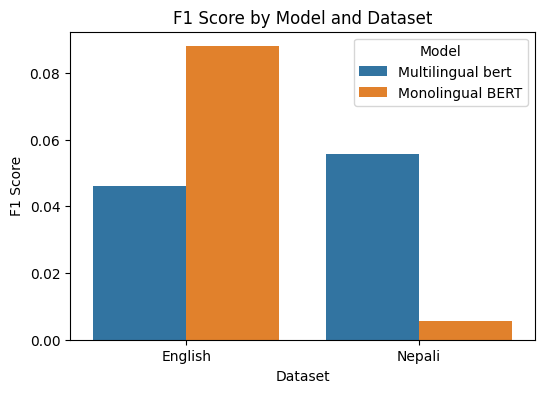

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Create the bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Dataset', y='F1_Score', hue='Model', data=df)
plt.title('F1 Score by Model and Dataset')
plt.ylabel('F1 Score')
plt.xlabel('Dataset')
plt.legend(title='Model')
plt.show()